<a href="https://colab.research.google.com/github/nitin-vig/ERAv4S8/blob/main/Cifar_100_with_Resnt50.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



# Cifar 100 with Resnt50

In [134]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from matplotlib import pyplot as plt
import albumentations as A
from albumentations.pytorch import ToTensorV2
import numpy as np

**Compute Mean and Standard Deviation for Normalization of data**. Commented as it is needed only once

In [135]:
# import torch
# from torchvision import datasets, transforms
# from torch.utils.data import DataLoader
# from tqdm import tqdm

# def get_mean_and_std(dataloader):
#     """
#     Calculate the mean and standard deviation of a dataset.

#     Args:
#         dataloader (DataLoader): The DataLoader for the dataset.

#     Returns:
#         tuple: The mean and standard deviation tensors for each channel.
#     """
#     channels_sum, channels_squared_sum, num_batches = 0, 0, 0
#     for data, _ in tqdm(dataloader, desc="Calculating mean and std"):
#         # Mean over batch, height, and width, but not over the channels
#         channels_sum += torch.mean(data, dim=[0, 2, 3])
#         channels_squared_sum += torch.mean(data**2, dim=[0, 2, 3])
#         num_batches += 1

#     mean = channels_sum / num_batches
#     # Std = sqrt(E[X^2] - (E[X])^2)
#     std = (channels_squared_sum / num_batches - mean ** 2) ** 0.5
#     return mean, std

# # 1. Load the dataset without normalization (only convert to tensor)
# # This will automatically download the dataset if it's not present
# transform = transforms.Compose([transforms.ToTensor()])
# train_dataset = datasets.CIFAR100(root='./data', train=True, download=True, transform=transform)

# # 2. Create a DataLoader
# train_loader = DataLoader(train_dataset, batch_size=128, shuffle=False)

# # 3. Get the mean and standard deviation
# mean, std = get_mean_and_std(train_loader)

# print('Calculated Mean:', mean)
# print('Calculated Standard Deviation:', std)

# 100%|██████████| 169M/169M [00:06<00:00, 27.9MB/s]
# Calculating mean and std: 100%|██████████| 391/391 [00:07<00:00, 50.50it/s]
# Calculated Mean: tensor([0.5070, 0.4865, 0.4409])
# Calculated Standard Deviation: tensor([0.2673, 0.2564, 0.2761])

In [136]:
# Train Phase transformations
# train_transforms = transforms.Compose([

#                                        transforms.ToTensor(),
#                                        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616),), # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values.
#                                        A.CoarseDropout(num_holes_range=(1,1),hole_height_range=(16,16),hole_width_range=(16,16),p=0.5),
#                                        A.HorizontalFlip(0.5),
#                                        A.ShiftScaleRotate(shift_limit=1,scale_limit=1,rotate_limit=1,p=0.5)
#                                        ])
# Define your Albumentations pipeline
import albumentations as A
from albumentations.pytorch import ToTensorV2
import numpy as np

CIFAR_MEAN = (0.5070, 0.4865, 0.4409)
CIFAR_STD  = (0.2673, 0.2564, 0.2761)

# train_alb = A.Compose([
#     # pad 4 px each side -> random crop 32x32 (equivalent to RandomCrop(pad=4))
#     A.PadIfNeeded(min_height=36, min_width=36, border_mode=0, value=None),
#     A.RandomCrop(height=32, width=32),

#     # spatial
#     A.HorizontalFlip(p=0.5),
#     A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.08, rotate_limit=10, border_mode=0, p=0.5),

#     # color / brightness / contrast variations
#     A.OneOf([
#         A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2),
#         A.HueSaturationValue(hue_shift_limit=8, sat_shift_limit=10, val_shift_limit=8),
#         A.RGBShift(r_shift_limit=10, g_shift_limit=10, b_shift_limit=10),
#     ], p=0.8),

#     # small blur / noise sometimes
#     A.OneOf([A.GaussianBlur(blur_limit=(1,3)), A.GaussNoise(var_limit=(1.0, 10.0))], p=0.25),

#     # CoarseDropout as Cutout: smaller holes for CIFAR (use max 6-8 px)
#     A.CoarseDropout(max_holes=1, max_height=8, max_width=8,
#                     min_holes=1, min_height=8, min_width=8,
#                     fill_value=tuple([int(m * 255) for m in CIFAR_MEAN]),
#                     p=0.5),

#     A.Normalize(mean=CIFAR_MEAN, std=CIFAR_STD),
#     ToTensorV2(),
# ])

train_alb = A.Compose([
    A.PadIfNeeded(min_height=40, min_width=40, border_mode=0, value=0, p=1.0),  # Pad first
    A.RandomCrop(32, 32, p=1.0),  # Then crop
    A.HorizontalFlip(p=0.5),
    A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.15, rotate_limit=15, p=0.5),
    A.OneOf([
        A.CoarseDropout(
            max_holes=1,
            max_height=16,
            max_width=16,
            min_height=8,
            min_width=8,
            fill_value=tuple([int(x * 255) for x in [0.5071, 0.4867, 0.4408]]),
            p=1.0
        ),
        A.GaussNoise(var_limit=(10.0, 50.0), p=1.0),
    ], p=0.3),
    A.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761)),
    ToTensorV2(),
])

# test: only normalize + tensor
test_alb = A.Compose([
    A.Normalize(mean=CIFAR_MEAN, std=CIFAR_STD),
    ToTensorV2(),
])

# wrapper functions for torchvision CIFAR100 dataset
def alb_train_transform(img):
    if not isinstance(img, np.ndarray):
        img = np.array(img)
    return train_alb(image=img)["image"]

def alb_test_transform(img):
    if not isinstance(img, np.ndarray):
        img = np.array(img)
    return test_alb(image=img)["image"]



/tmp/ipython-input-3906979243.py:48: UserWarning: Argument(s) 'value' are not valid for transform PadIfNeeded
  A.PadIfNeeded(min_height=40, min_width=40, border_mode=0, value=0, p=1.0),  # Pad first
/tmp/ipython-input-3906979243.py:53: UserWarning: Argument(s) 'max_holes, max_height, max_width, min_height, min_width, fill_value' are not valid for transform CoarseDropout
  A.CoarseDropout(
/tmp/ipython-input-3906979243.py:62: UserWarning: Argument(s) 'var_limit' are not valid for transform GaussNoise
  A.GaussNoise(var_limit=(10.0, 50.0), p=1.0),


In [137]:
train = datasets.CIFAR100('./data', train=True, download=True, transform=alb_train_transform)
test = datasets.CIFAR100('./data', train=False, download=True, transform=alb_test_transform)

In [138]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


Traceback (most recent call last):
  File "/usr/lib/python3.12/multiprocessing/queues.py", line 259, in _feed
    reader_close()
  File "/usr/lib/python3.12/multiprocessing/connection.py", line 178, in close
    self._close()
  File "/usr/lib/python3.12/multiprocessing/connection.py", line 377, in _close
    _close(self._handle)
OSError: [Errno 9] Bad file descriptor


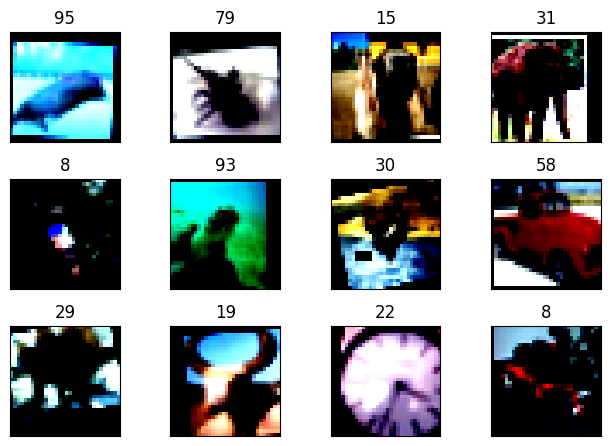

In [139]:
import matplotlib.pyplot as plt

batch_data, batch_label = next(iter(train_loader))

fig = plt.figure()

for i in range(12):
  plt.subplot(3,4,i+1)
  plt.tight_layout()
  # plt.imshow(batch_data[i].squeeze(0), cmap='gray')
  plt.imshow(batch_data[i].permute(1,2,0))

  plt.title(batch_label[i].item())
  plt.xticks([])
  plt.yticks([])

In [140]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import CIFAR100
from tqdm import tqdm


# Bottleneck block (same as before)
class Bottleneck(nn.Module):
 expansion = 4

 def __init__(self, in_channels, out_channels, stride=1, downsample=None):
  super(Bottleneck, self).__init__()
  self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False)
  self.bn1 = nn.BatchNorm2d(out_channels)

  self.conv2 = nn.Conv2d(
   out_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False
  )
  self.bn2 = nn.BatchNorm2d(out_channels)

  self.conv3 = nn.Conv2d(
   out_channels, out_channels * self.expansion, kernel_size=1, bias=False
  )
  self.bn3 = nn.BatchNorm2d(out_channels * self.expansion)

  self.relu = nn.ReLU(inplace=True)
  self.downsample = downsample

 def forward(self, x):
  identity = x

  out = self.conv1(x)
  out = self.bn1(out)
  out = self.relu(out)

  out = self.conv2(out)
  out = self.bn2(out)
  out = self.relu(out)

  out = self.conv3(out)
  out = self.bn3(out)

  if self.downsample is not None:
   identity = self.downsample(x)

  out += identity
  out = self.relu(out)
  return out


# ResNet tailored for CIFAR (no initial 7x7 stride-2 conv + no maxpool)
class ResNetCIFAR(nn.Module):
 def __init__(self, block, layers, num_classes=100):
  super(ResNetCIFAR, self).__init__()
  self.in_channels = 64

  # Adjusted first conv for CIFAR (3x3, stride=1)
  self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
  self.bn1 = nn.BatchNorm2d(64)
  self.relu = nn.ReLU(inplace=True)

  # NOTE: we do NOT use the 7x7 stride-2 conv or the 3x3 maxpool used for ImageNet
  # Stage layers
  self.layer1 = self._make_layer(block, 64, layers[0], stride=1)
  self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
  self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
  self.layer4 = self._make_layer(block, 512, layers[3], stride=2)

  self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
  self.fc = nn.Linear(512 * block.expansion, num_classes)

  # Weight initialization
  for m in self.modules():
   if isinstance(m, nn.Conv2d):
    nn.init.kaiming_normal_(m.weight, mode="fan_out", nonlinearity="relu")
   elif isinstance(m, nn.BatchNorm2d):
    nn.init.constant_(m.weight, 1)
    nn.init.constant_(m.bias, 0)

 def _make_layer(self, block, out_channels, blocks, stride=1):
  downsample = None
  if stride != 1 or self.in_channels != out_channels * block.expansion:
   downsample = nn.Sequential(
    nn.Conv2d(
     self.in_channels,
     out_channels * block.expansion,
     kernel_size=1,
     stride=stride,
     bias=False,
    ),
    nn.BatchNorm2d(out_channels * block.expansion),
   )

  layers = []
  layers.append(block(self.in_channels, out_channels, stride, downsample))
  self.in_channels = out_channels * block.expansion
  for _ in range(1, blocks):
   layers.append(block(self.in_channels, out_channels))

  return nn.Sequential(*layers)

 def forward(self, x):
  x = self.conv1(x)
  x = self.bn1(x)
  x = self.relu(x)
  # no maxpool

  x = self.layer1(x)
  x = self.layer2(x)
  x = self.layer3(x)
  x = self.layer4(x)

  x = self.avgpool(x)
  x = torch.flatten(x, 1)
  x = self.fc(x)
  return x


def resnet50_cifar(num_classes=100):
 return ResNetCIFAR(Bottleneck, [3, 4, 6, 3], num_classes=num_classes)

In [141]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = resnet50_cifar().to(device)
summary(model, input_size=(3, 32, 32))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
            Conv2d-4           [-1, 64, 32, 32]           4,096
       BatchNorm2d-5           [-1, 64, 32, 32]             128
              ReLU-6           [-1, 64, 32, 32]               0
            Conv2d-7           [-1, 64, 32, 32]          36,864
       BatchNorm2d-8           [-1, 64, 32, 32]             128
              ReLU-9           [-1, 64, 32, 32]               0
           Conv2d-10          [-1, 256, 32, 32]          16,384
      BatchNorm2d-11          [-1, 256, 32, 32]             512
           Conv2d-12          [-1, 256, 32, 32]          16,384
      BatchNorm2d-13          [-1, 256, 32, 32]             512
             ReLU-14          [-1,

In [142]:
import torch

def topk_accuracy(output, target, k=5):
    """
    Calculates the top-k accuracy for a given output and target.

    Args:
        output (torch.Tensor): The model's raw output logits, typically from the last layer.
        target (torch.Tensor): The ground-truth labels.
        k (int): The number of top predictions to consider.

    Returns:
        float: The top-k accuracy.
    """
    with torch.no_grad():
        # Get the top k predictions
        _, topk_preds = output.topk(k, dim=1, largest=True, sorted=True)

        # Reshape the target tensor for comparison
        target_reshaped = target.view(1, -1).expand_as(topk_preds)

        # Check if any of the top k predictions match the true label
        correct = (topk_preds == target_reshaped)

        # Calculate the number of correct predictions
        correct_count = correct.any(dim=0).sum().item()

        # Return the accuracy as a percentage
        return (correct_count / target.size(0))


In [143]:

model = resnet50_cifar().to(device)
# optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9)
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=40, gamma=0.1) ## Learning: adjust LR to a smaller value after every 5 epochs for fine tuning
# optimizer = optim.Adam(model.parameters(), lr=0.005)
# scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=100)
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=50)

In [144]:
from tqdm import tqdm
import torch
import torch.nn.functional as F

train_losses = []
test_losses = []
train_acc = []
test_acc = []
test_top5_acc = [] # New list to store top-5 accuracy

def train(model, device, train_loader, optimizer, epoch):
    model.train()
    pbar = tqdm(train_loader)
    correct = 0
    processed = 0
    for batch_idx, (data, target) in enumerate(pbar):
        data, target = data.to(device), target.to(device)

        optimizer.zero_grad()
        y_pred = model(data)
        loss = F.cross_entropy(y_pred, target)
        train_losses.append(loss.item())

        loss.backward()
        optimizer.step()

        pred = y_pred.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()
        processed += len(data)

        pbar.set_description(desc=f'Loss={loss.item():.4f} Batch_id={batch_idx} Accuracy={100*correct/processed:.2f}%')
        train_acc.append(100*correct/processed)

    # Note: The learning rate scheduler should be called at the end of the epoch,
    # as is standard practice.
    # scheduler.step()

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    correct_top1 = 0
    correct_top5 = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.cross_entropy(output, target, reduction='sum').item()

            # Top-1 accuracy calculation
            pred_top1 = output.argmax(dim=1, keepdim=True)
            correct_top1 += pred_top1.eq(target.view_as(pred_top1)).sum().item()

            # Top-5 accuracy calculation
            # correct_top5 += topk_accuracy(output, target, k=5)

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    top1_acc = 100. * correct_top1 / len(test_loader.dataset)
    # top5_acc = 100. * correct_top5 / len(test_loader.dataset)

    print(f'\nTest set: Average loss: {test_loss:.4f} ,Top-1 Accuracy: {correct_top1}/{len(test_loader.dataset)} ({top1_acc:.2f}%)%\n')

    test_acc.append(top1_acc)
    # test_top5_acc.append(top5_acc)


In [145]:
# import torch
# import torch.nn as nn
# import torch.nn.functional as F
# import torch.optim as optim
# from torch.utils.data import DataLoader
# import torchvision
# import torchvision.transforms as transforms
# from torchvision.datasets import CIFAR100
# from tqdm import tqdm
# import matplotlib.pyplot as plt
# import numpy as np

# # --- (Your model classes: Bottleneck, ResNetCIFAR, resnet50_cifar) ---
# # Paste your model code here or ensure it's in the same scope.

# def lr_finder(model, device, train_loader, optimizer, criterion, start_lr, end_lr, num_iter):
#     # Save the initial state of the model and optimizer
#     initial_model_state = model.state_dict()
#     initial_optimizer_state = optimizer.state_dict()

#     # Create a temporary scheduler
#     lr_lambda = lambda iteration: (end_lr / start_lr)**(iteration / num_iter)
#     scheduler = optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)

#     # Move model to device and set to training mode
#     model.to(device)
#     model.train()

#     lrs = []
#     losses = []

#     # Start with a very low learning rate
#     for param_group in optimizer.param_groups:
#         param_group['lr'] = start_lr

#     # Begin the LR search
#     pbar = tqdm(enumerate(train_loader), total=num_iter)
#     for batch_idx, (data, target) in pbar:
#         if batch_idx >= num_iter:
#             break

#         # Get samples and move to device
#         data, target = data.to(device), target.to(device)

#         # Zero gradients
#         optimizer.zero_grad()

#         # Predict and calculate loss
#         y_pred = model(data)
#         loss = criterion(y_pred, target)

#         # Backpropagation
#         loss.backward()
#         optimizer.step()

#         # --- FIX: Access the learning rate correctly ---
#         # The optimizer.param_groups is a list, so indexing with an integer is necessary.
#         lrs.append(optimizer.param_groups[0]['lr'])
#         losses.append(loss.item())

#         # Step the scheduler to increase LR
#         scheduler.step()

#         # Update progress bar
#         pbar.set_description(desc=f'LR: {lrs[-1]:.6f}, Loss: {losses[-1]:.4f}')

#     # Reset model and optimizer to their initial states
#     model.load_state_dict(initial_model_state)
#     optimizer.load_state_dict(initial_optimizer_state)

#     return lrs, losses

# def plot_lr_finder(lrs, losses, skip_start=10, skip_end=5):
#     # Smooth the loss curve
#     smoothed_losses = []
#     for i in range(len(losses)):
#         smoothed_losses.append(np.mean(losses[max(0, i - 10):i + 1]))

#     # Plot the results
#     plt.figure(figsize=(10, 6))
#     plt.plot(lrs[skip_start:-skip_end], smoothed_losses[skip_start:-skip_end])
#     plt.xscale('log')
#     plt.xlabel('Learning Rate (log scale)')
#     plt.ylabel('Loss')
#     plt.title('Learning Rate Finder')
#     plt.grid(True)
#     plt.show()


# if __name__ == '__main__':
#     # 1. Device configuration
#     device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#     # 3. Model, Loss, and Adam Optimizer
#     criterion = nn.CrossEntropyLoss()
#     optimizer = optim.Adam(model.parameters(), lr=1e-7)

#     # 4. Run the LR Finder test
#     start_lr = 1e-7
#     end_lr = 1e-1
#     num_iter = 300

#     print("Starting LR Finder...")
#     lrs, losses = lr_finder(model, device, train_loader, optimizer, criterion, start_lr, end_lr, num_iter)
#     print("LR Finder finished.")

#     # 5. Plot and suggest LR
#     plot_lr_finder(lrs, losses


In [146]:
EPOCHS = 100
for epoch in range(EPOCHS):
    print("EPOCH:", epoch+1)
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

EPOCH: 1


Loss=3.9321 Batch_id=390 Accuracy=6.70%: 100%|██████████| 391/391 [02:38<00:00,  2.46it/s]



Test set: Average loss: 23.9258 ,Top-1 Accuracy: 936/10000 (9.36%)%

EPOCH: 2


Loss=3.1624 Batch_id=390 Accuracy=14.76%: 100%|██████████| 391/391 [02:37<00:00,  2.48it/s]



Test set: Average loss: 3.4850 ,Top-1 Accuracy: 1810/10000 (18.10%)%

EPOCH: 3


Loss=2.7384 Batch_id=390 Accuracy=21.92%: 100%|██████████| 391/391 [02:38<00:00,  2.47it/s]



Test set: Average loss: 2.9600 ,Top-1 Accuracy: 2743/10000 (27.43%)%

EPOCH: 4


Loss=2.4910 Batch_id=390 Accuracy=28.83%: 100%|██████████| 391/391 [02:38<00:00,  2.47it/s]



Test set: Average loss: 2.5775 ,Top-1 Accuracy: 3406/10000 (34.06%)%

EPOCH: 5


Loss=2.4860 Batch_id=390 Accuracy=34.39%: 100%|██████████| 391/391 [02:38<00:00,  2.47it/s]



Test set: Average loss: 2.3791 ,Top-1 Accuracy: 3867/10000 (38.67%)%

EPOCH: 6


Loss=2.7651 Batch_id=390 Accuracy=38.55%: 100%|██████████| 391/391 [02:38<00:00,  2.47it/s]



Test set: Average loss: 2.1087 ,Top-1 Accuracy: 4292/10000 (42.92%)%

EPOCH: 7


Loss=1.9039 Batch_id=390 Accuracy=42.83%: 100%|██████████| 391/391 [02:37<00:00,  2.48it/s]



Test set: Average loss: 2.1089 ,Top-1 Accuracy: 4527/10000 (45.27%)%

EPOCH: 8


Loss=1.7541 Batch_id=390 Accuracy=46.06%: 100%|██████████| 391/391 [02:37<00:00,  2.48it/s]



Test set: Average loss: 1.8808 ,Top-1 Accuracy: 4882/10000 (48.82%)%

EPOCH: 9


Loss=1.6534 Batch_id=390 Accuracy=48.70%: 100%|██████████| 391/391 [02:37<00:00,  2.48it/s]



Test set: Average loss: 1.7559 ,Top-1 Accuracy: 5154/10000 (51.54%)%

EPOCH: 10


Loss=1.7156 Batch_id=390 Accuracy=51.57%: 100%|██████████| 391/391 [02:37<00:00,  2.48it/s]



Test set: Average loss: 1.7418 ,Top-1 Accuracy: 5420/10000 (54.20%)%

EPOCH: 11


Loss=1.3732 Batch_id=390 Accuracy=53.27%: 100%|██████████| 391/391 [02:38<00:00,  2.47it/s]



Test set: Average loss: 2.4508 ,Top-1 Accuracy: 5533/10000 (55.33%)%

EPOCH: 12


Loss=1.4093 Batch_id=390 Accuracy=55.86%: 100%|██████████| 391/391 [02:37<00:00,  2.48it/s]



Test set: Average loss: 3.2151 ,Top-1 Accuracy: 5742/10000 (57.42%)%

EPOCH: 13


Loss=1.4854 Batch_id=390 Accuracy=57.96%: 100%|██████████| 391/391 [02:38<00:00,  2.47it/s]



Test set: Average loss: 1.4861 ,Top-1 Accuracy: 5950/10000 (59.50%)%

EPOCH: 14


Loss=1.2455 Batch_id=390 Accuracy=59.80%: 100%|██████████| 391/391 [02:37<00:00,  2.48it/s]



Test set: Average loss: 1.5134 ,Top-1 Accuracy: 5969/10000 (59.69%)%

EPOCH: 15


Loss=1.3357 Batch_id=390 Accuracy=61.18%: 100%|██████████| 391/391 [02:37<00:00,  2.48it/s]



Test set: Average loss: 1.3929 ,Top-1 Accuracy: 6139/10000 (61.39%)%

EPOCH: 16


Loss=1.0888 Batch_id=390 Accuracy=62.75%: 100%|██████████| 391/391 [02:37<00:00,  2.48it/s]



Test set: Average loss: 1.4104 ,Top-1 Accuracy: 6164/10000 (61.64%)%

EPOCH: 17


Loss=1.2390 Batch_id=390 Accuracy=63.55%: 100%|██████████| 391/391 [02:37<00:00,  2.48it/s]



Test set: Average loss: 1.4149 ,Top-1 Accuracy: 6174/10000 (61.74%)%

EPOCH: 18


Loss=1.0990 Batch_id=390 Accuracy=65.28%: 100%|██████████| 391/391 [02:37<00:00,  2.48it/s]



Test set: Average loss: 1.3800 ,Top-1 Accuracy: 6327/10000 (63.27%)%

EPOCH: 19


Loss=1.1826 Batch_id=390 Accuracy=66.75%: 100%|██████████| 391/391 [02:37<00:00,  2.48it/s]



Test set: Average loss: 1.3102 ,Top-1 Accuracy: 6452/10000 (64.52%)%

EPOCH: 20


Loss=0.9868 Batch_id=390 Accuracy=68.02%: 100%|██████████| 391/391 [02:38<00:00,  2.47it/s]



Test set: Average loss: 1.3159 ,Top-1 Accuracy: 6568/10000 (65.68%)%

EPOCH: 21


Loss=1.3704 Batch_id=390 Accuracy=69.29%: 100%|██████████| 391/391 [02:37<00:00,  2.47it/s]



Test set: Average loss: 1.3313 ,Top-1 Accuracy: 6492/10000 (64.92%)%

EPOCH: 22


Loss=0.7927 Batch_id=390 Accuracy=70.63%: 100%|██████████| 391/391 [02:38<00:00,  2.47it/s]



Test set: Average loss: 1.2949 ,Top-1 Accuracy: 6601/10000 (66.01%)%

EPOCH: 23


Loss=0.9818 Batch_id=390 Accuracy=71.96%: 100%|██████████| 391/391 [02:37<00:00,  2.48it/s]



Test set: Average loss: 1.3043 ,Top-1 Accuracy: 6713/10000 (67.13%)%

EPOCH: 24


Loss=1.0825 Batch_id=390 Accuracy=72.47%: 100%|██████████| 391/391 [02:38<00:00,  2.47it/s]



Test set: Average loss: 1.3650 ,Top-1 Accuracy: 6649/10000 (66.49%)%

EPOCH: 25


Loss=0.8392 Batch_id=390 Accuracy=73.34%: 100%|██████████| 391/391 [02:38<00:00,  2.47it/s]



Test set: Average loss: 1.3111 ,Top-1 Accuracy: 6727/10000 (67.27%)%

EPOCH: 26


Loss=0.8983 Batch_id=390 Accuracy=74.58%: 100%|██████████| 391/391 [02:38<00:00,  2.47it/s]



Test set: Average loss: 1.3114 ,Top-1 Accuracy: 6721/10000 (67.21%)%

EPOCH: 27


Loss=1.0721 Batch_id=390 Accuracy=75.63%: 100%|██████████| 391/391 [02:37<00:00,  2.48it/s]



Test set: Average loss: 1.3233 ,Top-1 Accuracy: 6789/10000 (67.89%)%

EPOCH: 28


Loss=0.9872 Batch_id=128 Accuracy=77.07%:  33%|███▎      | 129/391 [00:53<01:47,  2.43it/s]


KeyboardInterrupt: 

In [ ]:
t = [t_items.item() for t_items in train_losses]
%matplotlib inline
import matplotlib.pyplot as plt
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(t)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc[4000:])
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")